In [8]:
from PIL import Image
import os

# Set the path to your dataset
main_dir = '/kaggle/input/brain-tumor-segmentation'

# Create empty lists to store images and masks
images_list = []
masks_list = []

# List all files in the 'images' directory
image_files = sorted(os.listdir(os.path.join(main_dir, 'images')))

# Iterate through image files
for image_file in image_files:
    # Construct the file paths
    image_path = os.path.join(main_dir, 'images', image_file)
    
    # Assuming mask filenames are in the 'masks' folder with the same name
    mask_file = image_file.replace('.jpg', '_mask.jpg')  # Adjust this based on your naming convention
    mask_path = os.path.join(main_dir, 'masks', mask_file)

    # Read images using PIL
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    # Append images to the lists
    images_list.append(image)
    masks_list.append(mask)

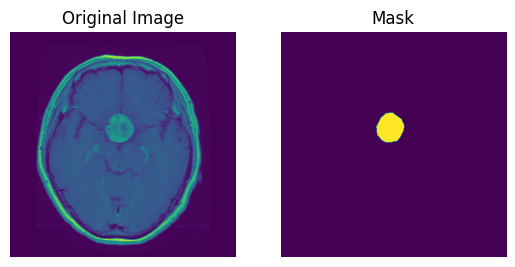

In [9]:
import matplotlib.pyplot as plt

# Choose an index to visualize
index_to_visualize = 25

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(images_list[index_to_visualize])
plt.title('Original Image')
plt.axis('off')

# Display the corresponding mask
plt.subplot(1, 2, 2)
plt.imshow(masks_list[index_to_visualize])
plt.title('Mask')
plt.axis('off')

# Show the plots
plt.show()


In [10]:

    
#resize images    
    
# Assuming images_list and masks_list are already populated

# Specify the target size
target_size = (256, 256)

# Create new lists to store resized images and masks
resized_images_list = []
resized_masks_list = []

for image, mask in zip(images_list, masks_list):
    # Resize images
    resized_image = image.resize(target_size, resample=Image.LANCZOS)
    resized_mask = mask.resize(target_size, resample=Image.LANCZOS)

    # Append resized images to the lists
    resized_images_list.append(resized_image)
    resized_masks_list.append(resized_mask)

# Now, resized_images_list and resized_masks_list contain the resized images and masks, respectively


In [11]:
import tensorflow as tf
from tensorflow.keras import layers

def unet_model(input_shape=(256, 256, 1)):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # Contracting Path
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(drop4)

    # Bottom layer
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Expansive Path
    up6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    concat6 = layers.concatenate([up6, drop4], axis=-1)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = layers.concatenate([up7, conv3], axis=-1)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = layers.concatenate([up8, conv2], axis=-1)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    conv8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = layers.concatenate([up9, conv1], axis=-1)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    conv9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Assuming you have resized images and masks in lists
# resized_images_list and resized_masks_list are assumed to be lists of PIL Image objects

# Convert PIL Images to NumPy arrays
images_array = np.array([np.array(image) for image in resized_images_list])
masks_array = np.array([np.array(mask) for mask in resized_masks_list])

# Normalize pixel values to the range [0, 1]
images_array = images_array / 255.0
masks_array = masks_array / 255.0

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images_array, masks_array, test_size=0.2, random_state=42)

# Create the U-Net model
model = unet_model()

# Compile the model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
eval_result = model.evaluate(X_test, y_test)
print("Test Loss:", eval_result[0])
print("Test Accuracy:", eval_result[1])


Epoch 1/3
77/77 [==============================] - 8906s 116s/step - loss: 0.1031 - accuracy: 0.9797 - val_loss: 0.0669 - val_accuracy: 0.9796
Epoch 2/3
77/77 [==============================] - 8226s 107s/step - loss: 0.0639 - accuracy: 0.9799 - val_loss: 0.0674 - val_accuracy: 0.9796
Epoch 3/3
20/20 [==============================] - 567s 28s/step - loss: 0.0532 - accuracy: 0.9813
Test Loss: 0.05320622771978378
Test Accuracy: 0.9812577366828918


/tmp/ipykernel_41/4098671034.py:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  input_image = input_image.resize((256, 256), Image.ANTIALIAS)  # Use Image.ANTIALIAS for high-quality resizing


1/1 [==============================] - 1s 943ms/step


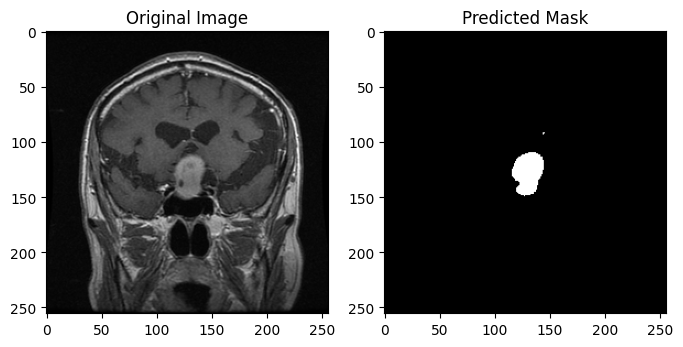

In [43]:
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load your image (replace 'path/to/your/image.jpg' with the actual path)
image_path = '/kaggle/input/brain-tumor-segmentation/images/1035.png'
input_image = Image.open(image_path)

# Resize the image to 256x256
input_image = input_image.resize((256, 256), Image.ANTIALIAS)  # Use Image.ANTIALIAS for high-quality resizing

# Convert the PIL image to a NumPy array
input_array = np.array(input_image)/255.0

# Preprocess the image if needed (normalize pixel values, etc.)
# ...

# Expand dimensions to match the model's expected input shape
input_array = np.expand_dims(input_array, axis=0)

# Make predictions using the loaded model
predictions = model.predict(input_array)

# Threshold predictions (adjust as needed)
threshold = 0.15
predicted_mask = (predictions > threshold).astype(np.uint8)

# Visualize the original image and predicted mask
plt.figure(figsize=(8, 4))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(input_array.squeeze(), cmap='gray')
plt.title('Original Image')

# Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

# If you have ground truth information, load it and evaluate the model
# ground_truth_mask = load_ground_truth_mask()  # Load your ground truth mask if available
# ...

# Evaluate performance
# accuracy = accuracy_score(ground_truth_mask.flatten(), predicted_mask.flatten())
# precision = precision_score(ground_truth_mask.flatten(), predicted_mask.flatten())
# recall = recall_score(ground_truth_mask.flatten(), predicted_mask.flatten())
# f1 = f1_score(ground_truth_mask.flatten(), predicted_mask.flatten())
# ...

# Print or use the evaluation metrics as needed
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1)


In [44]:
model.save('/kaggle/working/brain_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [48]:
from tensorflow.keras.models import load_model
model2=load_model('/kaggle/working/brain_model.h5')
model.save('/kaggle/working/brain_model2.h5')

In [54]:
import os 
os.chdir(r'/kaggle/working') 
model.save('/kaggle/working/brain_model.h5')
from IPython.display import FileLink 
FileLink(r'brain_model.h5')

/kaggle/working/brain_model.h5